In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pyhank import HankelTransform
from datetime import datetime
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/testing/wide_domain


In [2]:
#Load simulation data
_, times = load_data('th1_xz')
var1, var2 = load_az_data('w_az', 'b_az')
NSAMP = len(times)

var2 = np.gradient(var2, gzf, axis=1)
var2 = np.gradient(var2, times, axis=0)

print(var1.shape)

times, t0_idx = calibrate_time(save_dir, times)

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)


Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Az keys: <KeysViewHDF5 ['b_az', 'bb_sfluc', 'p_az', 'th_az', 'u_az', 'ub_sfluc', 'uth_sfluc', 'uu_sfluc', 'uv_sfluc', 'uw_sfluc', 'v_az', 'vv_sfluc', 'vw_sfluc', 'w_az', 'wb_sfluc', 'ww_sfluc']>
(211, 257, 256)
Plume penetration occured at t=2.7327


In [3]:
print(md)

{'LX': 1.0, 'LY': 1.0, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 30.0, 'VERSION': 3.9, 'NU_START_TIME': 10.0, 'SAVE_STATS_DT_FINE': 0.1, 'FINE_RES_TIME': 5.0, 'TIME_LIMIT': 23.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 3.0625, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 512, 'Ny': 512, 'Nz': 257, 'Nth': 2}


In [4]:
dr = md['LX']/md['Nx']
nbins = int(md['Nx']/2)
r_bins = np.array([r*dr for r in range(0, nbins+1)])
r_points = np.array([0.5*(r_bins[i]+r_bins[i+1]) for i in range(nbins)])

X, Y = np.meshgrid(r_bins, gz)
Xf, Yf = np.meshgrid(r_points, gzf)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 211
Dimensional times:  [-2.73272397 -2.48272397 -2.23272397 -1.98272397 -1.73272397 -1.48272397
 -1.23272397 -0.98272397 -0.73272397 -0.48272397 -0.23272397  0.
  0.25        0.5         0.75        1.          1.25        1.5
  1.75        2.          2.25        2.5         2.75        3.
  3.25        3.5         3.75        4.          4.25        4.5
  4.75        5.          5.1         5.2         5.3         5.4
  5.5         5.6         5.7         5.8         5.9         6.
  6.1         6.2         6.3         6.4         6.5         6.6
  6.7         6.8         6.9         7.          7.1         7.2
  7.3         7.4         7.5         7.6         7.7         7.8
  7.9         8.          8.1         8.2         8.3         8.4
  8.5         8.6         8.7         8.8         8.9         9.
  9.1         9.2         9.3         9.4         9.5         9.6
  9.7         9.8         9.9        10.         10.1        10.2
 10.3        10.4        10.5  

Setting up data arrays...
Setting up initial plot...
Starting plot...


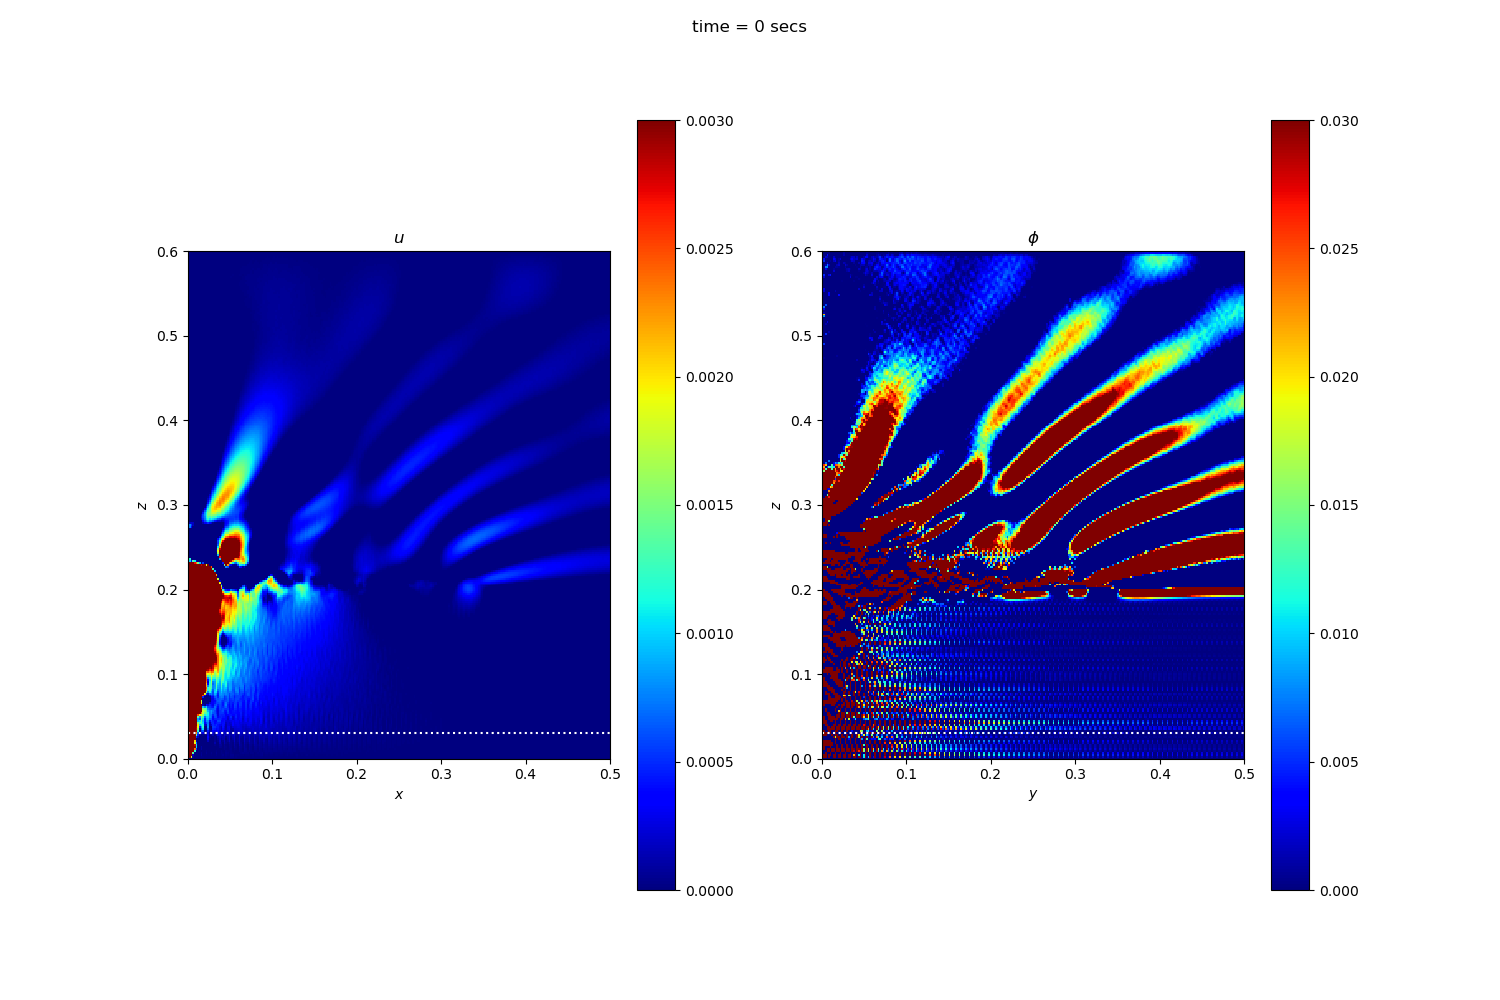

In [5]:
print("Setting up data arrays...")
fig, axs = plt.subplots(1,2,figsize=(15, 10))
ims = np.array([None,None])
cb = np.array([None,None])

print("Setting up initial plot...")
ims[0] = axs[0].pcolormesh(X, Y, var1[-1], cmap='jet')
ims[1] = axs[1].pcolormesh(X, Y, var2[-1], cmap='jet')

# Add forcing level
axs[0].axhline(md['Lyc']+md['Lyp'],color='white', linestyle=':')
axs[1].axhline(md['Lyc']+md['Lyp'],color='white', linestyle=':')

cb[0] = plt.colorbar(ims[0],ax=axs[0])
cb[1] = plt.colorbar(ims[1],ax=axs[1])

ims[0].set_clim(0, 3e-3)
ims[1].set_clim(0, 3e-2)

fig.suptitle("time = 0 secs")
axs[0].set_ylabel("$z$")
axs[1].set_ylabel("$z$")
axs[0].set_xlabel("$x$")
axs[1].set_xlabel("$y$")

axs[0].set_ylim(0, 3*md['H'])
axs[1].set_ylim(0, 3*md['H'])

#axs[0].set_xlim(0.2, 0.4)
#axs[1].set_xlim(0.2, 0.4)

axs[0].set_aspect(1)
axs[1].set_aspect(1)

axs[0].set_title(r"$u$")
axs[1].set_title(r"$\phi$")

def animate(step):
    ims[0].set_array(var1[step].ravel())
    ims[1].set_array(var2[step].ravel())
    fig.suptitle("time = {0:.2f} secs".format(times[step]))

    return ims.flatten(),

#print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(fig, animate, interval=100, frames=NSAMP, repeat=True)
now = datetime.now()
#anim.save(save_dir+'shear_%s.mp4'%now.strftime("%d-%m-%Y"),writer=writer)
plt.show()